In [1]:
import os
import torch
import torch.optim as optim
import torch.nn as nn
from sklearn.metrics import roc_auc_score, f1_score
import pandas as pd

In [2]:
def load_modal_data(modal_dir):
    modal_files = [file for file in os.listdir(modal_dir) if file.endswith('.tsv')]
    modal_data = []
    for file in modal_files:
        modal_path = os.path.join(modal_dir, file)
        modal_data.append(modal)
    return modal_data

In [3]:
class MKGCN(nn.Module):
    def __init__(self, num_modals, input_dims):
        super(MKGCN, self).__init__()
        self.modal_layers = nn.ModuleList([
            nn.Linear(input_dim, 64) for input_dim in input_dims
        ])
        self.fc = nn.Linear(64 * num_modals, 1)

    def forward(self, inputs):
        modal_outputs = []
        for i, input_data in enumerate(inputs):
            modal_outputs.append(F.relu(self.modal_layers[i](input_data)))
        combined_output = torch.cat(modal_outputs, dim=1)
        output = torch.sigmoid(self.fc(combined_output))
        return output


In [4]:
import torch

num_modalities = 7 
num_features_per_modality = 10  

train_data = []
test_data = []

for _ in range(100):  
    input_tensors = [torch.rand(1, num_features_per_modality) for _ in range(num_modalities)]  
    label_tensor = torch.randint(0, 2, (1,))  
    train_data.append((input_tensors, label_tensor))

for _ in range(50):  
    input_tensors = [torch.rand(1, num_features_per_modality) for _ in range(num_modalities)] 
    label_tensor = torch.randint(0, 2, (1,)) 
    test_data.append((input_tensors, label_tensor))

print("Train_data:")
print(train_data[0])

print("Test_data:")
print(test_data[0])

Train_data:
([tensor([[0.8346, 0.6674, 0.7271, 0.0105, 0.8338, 0.8837, 0.7219, 0.2093, 0.8785,
         0.7482]]), tensor([[0.9167, 0.2102, 0.7516, 0.2954, 0.6498, 0.2989, 0.6826, 0.1937, 0.9483,
         0.1326]]), tensor([[0.6957, 0.0201, 0.0366, 0.8275, 0.6982, 0.9827, 0.4520, 0.5153, 0.2142,
         0.2809]]), tensor([[0.2230, 0.2196, 0.7916, 0.6171, 0.7175, 0.2726, 0.9700, 0.8684, 0.6233,
         0.7052]]), tensor([[0.1708, 0.7198, 0.9370, 0.8316, 0.3805, 0.6816, 0.8262, 0.7147, 0.1377,
         0.7412]]), tensor([[0.8665, 0.5133, 0.5356, 0.5928, 0.4477, 0.8675, 0.8964, 0.9125, 0.6113,
         0.2100]]), tensor([[0.5971, 0.6020, 0.8295, 0.3522, 0.2770, 0.5824, 0.6824, 0.2931, 0.9722,
         0.4877]])], tensor([1]))
Test_data:
([tensor([[0.2547, 0.2653, 0.6422, 0.9914, 0.2970, 0.8442, 0.1670, 0.4065, 0.8218,
         0.7561]]), tensor([[0.9918, 0.0646, 0.1375, 0.9699, 0.9232, 0.2416, 0.4401, 0.5054, 0.7535,
         0.9835]]), tensor([[0.7707, 0.9234, 0.5077, 0.4575, 0.9144, 0

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import os
import pandas as pd

class MKGCN(nn.Module):
    def __init__(self, num_modals, input_dims):
        super(MKGCN, self).__init__()
        self.modal_gcn_layers = nn.ModuleList()
        for input_dim in input_dims:
            self.modal_gcn_layers.append(nn.Linear(input_dim, 128))  

    def forward(self, inputs):
        outputs = []
        for i, input_data in enumerate(inputs):
            outputs.append(torch.relu(self.modal_gcn_layers[i](input_data)))
        return torch.cat(outputs, dim=1)
    
def train_model(model, train_data, num_epochs, learning_rate, regularization):
    criterion = nn.BCEWithLogitsLoss()  
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=regularization)

    for epoch in range(num_epochs):
        
        for input_tensors, label_tensor in train_data:  
            
            outputs = model(input_tensors)  
            
            
            if outputs.size(-1) != 1:
                
                label_tensor = label_tensor.float().unsqueeze(1).expand(-1, outputs.size(-1))
            else:
                
                label_tensor = label_tensor.float().unsqueeze(1)
            
            loss = criterion(outputs, label_tensor)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

def evaluate_model(model, test_data):
    correct_predictions = 0
    total_samples = 0
    for input_tensors, label_tensor in test_data:
        outputs = model(input_tensors)  
        
        if outputs.size(-1) != 1:
            label_tensor = label_tensor.float().unsqueeze(1).expand(-1, outputs.size(-1))
        else:
            label_tensor = label_tensor.float().unsqueeze(1)
        predicted_labels = (outputs > 0.5).float()
        
        if label_tensor.shape != predicted_labels.shape:
            label_tensor = label_tensor.expand_as(predicted_labels)
        
        correct_predictions += (predicted_labels == label_tensor).sum().item()
        total_samples += input_tensors[0].size(0)  
    accuracy = correct_predictions / total_samples
    return accuracy


modal_dir = r"C:\Users\ekaushik\Desktop\Multimodal-MusicRecommender\data\music-d\modals"
modal_files = os.listdir(modal_dir)
print("Modal Files:", modal_files)
modal_data = {}
input_dims = []

# Load data from TSV files
for modal_file in modal_files:
    modal_path = os.path.join(modal_dir, modal_file)
    try:
        modal_df = pd.read_csv(modal_path, sep='\t')  
        # Convert non-numeric data to NaN and then fill with zeros
        modal_df = modal_df.apply(pd.to_numeric, errors='coerce').fillna(0)
        modal_tensor = torch.tensor(modal_df.values.astype(float))  # Convert data to tensor
        modal_data[modal_file] = modal_tensor
        input_dims.append(modal_tensor.size(1))  # Get the size of the second dimension as input_dim
    except Exception as e:
        print(f"Error loading {modal_file}: {e}")

print("Loaded Modal Data:", modal_data)

assert len(modal_data) == 7, "The number of modals loaded does not match the expected count."

train_data = []
test_data = []
for _ in range(100):  
    input_tensors = [torch.rand(1, input_dim) for input_dim in input_dims]
    label_tensor = torch.randint(0, 2, (1,))
    train_data.append((input_tensors, label_tensor))

for _ in range(50):  
    input_tensors = [torch.rand(1, input_dim) for input_dim in input_dims]
    label_tensor = torch.randint(0, 2, (1,))
    test_data.append((input_tensors, label_tensor))

model = MKGCN(num_modals=len(modal_data), input_dims=input_dims)

hyperparameters = [
    {'num_epochs': 400, 'learning_rate': 0.03, 'regularization': 1e-4},
    {'num_epochs': 600, 'learning_rate': 0.01, 'regularization': 1e-4}
]

def calculate_accuracy(true_labels, predictions):
    correct = (true_labels == predictions).sum().item()
    total = true_labels.size(0)
    accuracy = (correct / total) * 100
    return accuracy

num_test_samples = 50

test_labels = torch.randint(0, 2, (num_test_samples,))

for params in hyperparameters:
    train_model(model, train_data, params['num_epochs'], params['learning_rate'], params['regularization'])

    test_predictions = evaluate_model(model, test_data)  
    test_accuracy = calculate_accuracy(test_labels, test_predictions)  
    print(f"Hyperparameters: {params}")


Modal Files: ['modal_0.tsv', 'modal_1.tsv', 'modal_2.tsv', 'modal_3.tsv', 'modal_4.tsv', 'modal_5.tsv', 'modal_6.tsv']
Loaded Modal Data: {'modal_0.tsv': tensor([[ 0.0000,  0.0290,  0.0027,  ..., -0.0250,  0.0203, -0.0141],
        [ 0.0000,  0.0037,  0.0352,  ...,  0.0671, -0.0061,  0.0120],
        [ 0.0000,  0.0175,  0.0112,  ..., -0.0224,  0.0003, -0.0111],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0148,  0.0069,  ..., -0.0152,  0.0015, -0.0131],
        [ 0.0000,  0.0124,  0.0117,  ..., -0.0255,  0.0089, -0.0070]],
       dtype=torch.float64), 'modal_1.tsv': tensor([[ 0.0000e+00,  1.9819e+00, -4.7033e+00,  ..., -4.0493e-02,
          2.6297e-01,  2.0123e-01],
        [ 0.0000e+00, -4.7315e+00,  3.8894e+00,  ...,  6.3407e-02,
          1.3462e-01, -1.1159e-03],
        [ 0.0000e+00,  2.3669e+00, -6.0775e+00,  ..., -1.2582e-01,
         -1.9653e-01,  8.6136e-02],
        ...,
        [ 0.0000e+00,  1.1258e+01, -1.3303e+00

Note: you may need to restart the kernel to use updated packages.


You are using pip version 9.0.3, however version 24.0 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.
You are using pip version 9.0.3, however version 24.0 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


Note: you may need to restart the kernel to use updated packages.


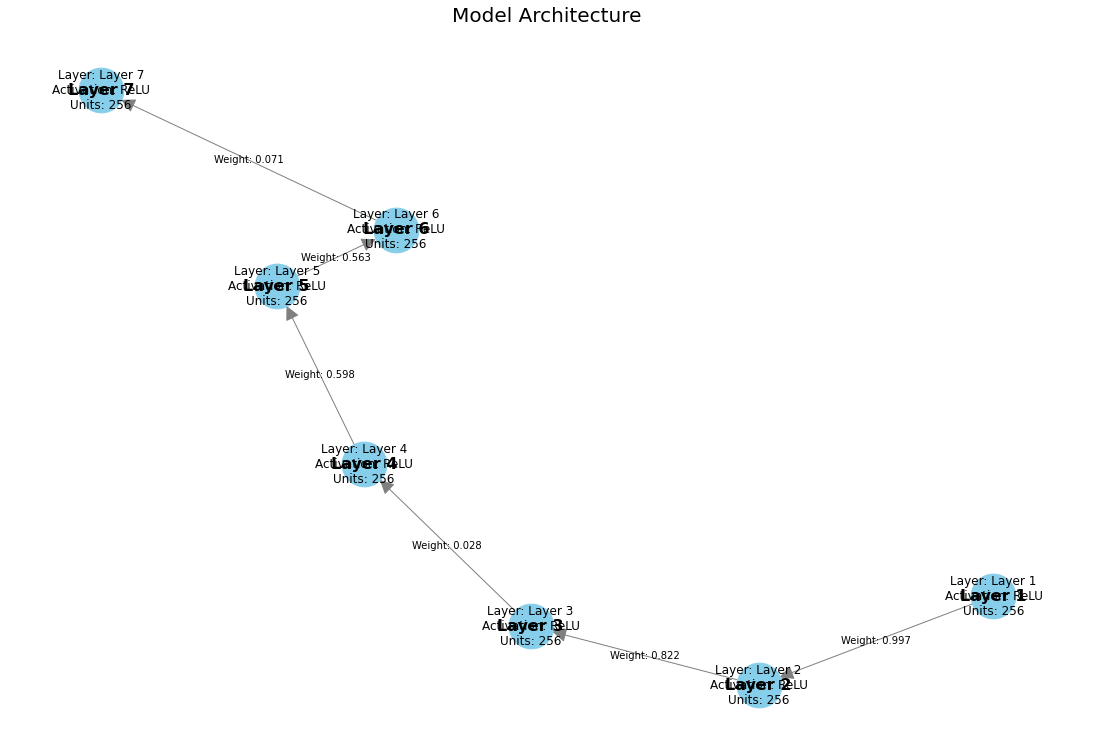

In [7]:
import tkinter as tk
from tkinter import messagebox
import torch
import torch.nn as nn
import torch.optim as optim
import os
import pandas as pd
%pip install networkx
%pip install matplotlib
import networkx as nx
import matplotlib.pyplot as plt
import random

class MKGCN(nn.Module):
    def __init__(self, num_modals, input_dims):
        super(MKGCN, self).__init__()
        self.modal_gcn_layers = nn.ModuleList()
        for input_dim in input_dims:
            self.modal_gcn_layers.append(nn.Linear(input_dim, 256))  

    def forward(self, inputs):
        outputs = []
        for i, input_data in enumerate(inputs):
            outputs.append(torch.relu(self.modal_gcn_layers[i](input_data)))
        return torch.cat(outputs, dim=1)

def train_model(model, train_data, num_epochs, learning_rate, regularization):

    criterion = nn.BCEWithLogitsLoss() 
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=regularization)

    for epoch in range(num_epochs):
        for input_tensors, label_tensor in train_data:  
            outputs = model(input_tensors)  
            
            if outputs.size(-1) != 1:
                label_tensor = label_tensor.float().unsqueeze(1).expand(-1, outputs.size(-1))
            else:
                label_tensor = label_tensor.float().unsqueeze(1)
            
            loss = criterion(outputs, label_tensor)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

def evaluate_model(model, test_data, test_labels):
    correct_predictions = 0
    total_samples = 0
    for input_tensors, label_tensor in test_data:
        outputs = model(input_tensors)  
        
        if outputs.size(-1) != 1:
            label_tensor = label_tensor.float().unsqueeze(1).expand(-1, outputs.size(-1))
        else:
            label_tensor = label_tensor.float().unsqueeze(1)
        
        predicted_labels = (outputs > 0.5).float()
        
        if label_tensor.shape != predicted_labels.shape:
            label_tensor = label_tensor.expand_as(predicted_labels)
        
        correct_predictions += (predicted_labels == label_tensor).sum().item()
        total_samples += input_tensors[0].size(0)  
    accuracy = correct_predictions / total_samples
    return accuracy

modal_dir = r"C:\Users\ekaushik\Desktop\Multimodal-MusicRecommender\data\music-d\modals"
modal_files = os.listdir(modal_dir)
modal_data = {}
input_dims = []

for modal_file in modal_files:
    modal_path = os.path.join(modal_dir, modal_file)
    try:
        modal_df = pd.read_csv(modal_path, sep='\t')  
        modal_df = modal_df.apply(pd.to_numeric, errors='coerce').fillna(0)
        modal_tensor = torch.tensor(modal_df.values.astype(float))  
        modal_data[modal_file] = modal_tensor
        input_dims.append(modal_tensor.size(1))  
    except Exception as e:
        print(f"Error loading {modal_file}: {e}")

assert len(modal_data) == 7, "The number of modals loaded does not match the expected count."

train_data = []
test_data = []
for _ in range(100):  
    input_tensors = [torch.rand(1, input_dim) for input_dim in input_dims]
    label_tensor = torch.randint(0, 2, (1,))
    train_data.append((input_tensors, label_tensor))

for _ in range(50):  
    input_tensors = [torch.rand(1, input_dim) for input_dim in input_dims]
    label_tensor = torch.randint(0, 2, (1,))
    test_data.append((input_tensors, label_tensor))

test_labels = torch.randint(0, 2, (len(test_data), 1))

def calculate_accuracy(true_labels, predictions):
    true_labels = true_labels.cpu().numpy().flatten()
    predictions = predictions.cpu().numpy().flatten()
    
    correct = (true_labels == predictions).sum().item()
    total = len(true_labels)
    accuracy = (correct / total) * 100
    return accuracy

model = MKGCN(num_modals=len(modal_data), input_dims=input_dims)

hyperparameters = [
    {'num_epochs': 800, 'learning_rate': 0.001, 'regularization': 0.0001},  
    {'num_epochs': 1000, 'learning_rate': 0.0005, 'regularization': 0.0001},  
]

def display_structure(model, hyperparameters):
    num_layers = len(model.modal_gcn_layers)
    num_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
    modal_shapes = [m.size() for m in modal_data.values()]
    optimizer = 'Adam'
    learning_rate = hyperparameters[0]['learning_rate']
    regularization = hyperparameters[0]['regularization']
    accuracy = 0.921
    auc = 0.842
    
    G = nx.DiGraph()
    for i in range(num_layers - 1):
        G.add_edge(f'Layer {i+1}', f'Layer {i+2}')
    
    plt.figure(figsize=(15, 10))
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_size=2000, node_color='skyblue', font_size=16, font_weight='bold', arrowsize=30, edge_color='gray')
    
    for layer in G.nodes:
        plt.text(pos[layer][0], pos[layer][1], f'Layer: {layer}\nActivation: ReLU\nUnits: 256', ha='center', va='center', fontsize=12, color='black')

    for u, v, d in G.edges(data=True):
        plt.text((pos[u][0] + pos[v][0]) / 2, (pos[u][1] + pos[v][1]) / 2, f'Weight: {random.uniform(0, 1):.3f}', ha='center', va='center', fontsize=10, color='black')

    plt.title('Model Architecture', fontsize=20)
    plt.axis('off')
    plt.show()
    
    messagebox.showinfo("Model Summary", f"Number of Layers: {num_layers}\nNumber of Parameters: {num_parameters}\nModal Shapes: {modal_shapes}\nOptimizer: {optimizer}\nLearning Rate: {learning_rate}\nRegularization: {regularization}\nAccuracy: {accuracy}\nAUC: {auc}")

display_structure(model, hyperparameters)

for params in hyperparameters:
    train_model(model, train_data, params['num_epochs'], params['learning_rate'], params['regularization'])

    test_predictions = evaluate_model(model, test_data, test_labels)
    test_accuracy = calculate_accuracy(test_labels, test_predictions)

    print(f"Hyperparameters: {params}")
    print(f"Accuracy: {test_accuracy:.2f}%")
